# Comprehensive Analysis of our Strategy


## Preparation

In [41]:
import numpy as np
import pandas as pd
import seaborn as sns
import glob 
import csv
import traceback
import datetime
import os
pd.options.display.max_columns=50
var = 'norm-precision'
import matplotlib.pyplot as plt

from collections import defaultdict
%matplotlib inline

In [42]:
def extract (prefixes, props = ['data', 'sampling', 'subsamplings',  'ada_decay', 'current_weights']):
    results = []
    for prefix in prefixes:
        results += glob.glob(f'../results/performances/{prefix}*')  # quick- or www21- or fld-
    list1, list2 = zip(*sorted(zip([os.stat(result).st_size for result in results], results)))


    full_results = defaultdict(list)

    # Retrieving results
    num_logs = len([i for i in list1 if i > 1000])
    count= 0
    for i in range(1,num_logs+1):
        try:
            df = pd.read_csv(list2[-i])
            rolling_mean7 = df[var].rolling(window=7).mean()
            rolling_mean14 = df[var].rolling(window=14).mean()
            filename = list2[-i][list2[-i].index('16'):list2[-i].index('16')+10]
            info = ','.join([str(x) for x in df[props].iloc[0]])
            full_results[info].append(rolling_mean14)
            count += 1

        except:
            print('loading error:', list2[-i])
            continue
    print(count)
    return full_results

In [43]:
def extract_ratios (prefixes, props = ['data', 'sampling', 'subsamplings',  'ada_decay', 'current_weights']):
    results = []
    for prefix in prefixes:
        results += glob.glob(f'../results/performances/{prefix}*')  # quick- or www21- or fld-
    list1, list2 = zip(*sorted(zip([os.stat(result).st_size for result in results], results)))


    full_results = defaultdict(list)
    weights = defaultdict(dict)

    # Retrieving results
    num_logs = len([i for i in list1 if i > 1000])
    count= 0
    for i in range(1,num_logs+1):
        try:
            df = pd.read_csv(list2[-i])
            filename = list2[-i][list2[-i].index('16'):list2[-i].index('16')+10]
            dataname = df['data'].iloc[0]
            weights[(filename, dataname)] = df['current_weights'].map(lambda x: float(x.split('/')[1])).rolling(window=14).mean()
            count += 1
    
        except:
            print('loading error:', list2[-i])
            continue
    print(count)
    return weights

In [44]:
def extract_weights (prefixes, props = ['data', 'sampling', 'subsamplings',  'ada_decay', 'current_weights']):
    results = []
    for prefix in prefixes:
        results += glob.glob(f'../results/ratios/{prefix}*')  # quick- or www21- or fld-
    list1, list2 = zip(*sorted(zip([os.stat(result).st_size for result in results], results)))


    full_results = defaultdict(list)
    weights = defaultdict(dict)

    # Retrieving results
    num_logs = len([i for i in list1 if i > 1000])
    count= 0
    for i in range(1,num_logs+1):
        try:
            cols = [f'{i/20} explore rate' for i in range(20)]
            df = pd.read_csv(list2[-i])
            filename = list2[-i][list2[-i].index('16'):list2[-i].index('16')+10]
            dataname = df['data'].iloc[0]
            weights[(filename, dataname)] = df[cols].transpose()
            count += 1
    
        except:
            print('loading error:', list2[-i])
            continue
    print(count)
    return weights


In [45]:
def draw(full_results, data = 'real-t', 
            cond = lambda x: True, 
            label2key = lambda x: x,
            title = '<Tdata> Train: 1 months, Valid: 28 days, Test: 7 days, direct decay'):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    # info = ','.join(list(df[['data', 'samplings']].iloc[0]))
    plt.style.use('seaborn-dark')

    result_one_dataset = sorted([key for key in full_results.keys() if data in key and cond(key)])
    colors = sns.color_palette("icefire", len(result_one_dataset))
    ax.set_prop_cycle('color', colors)
    print('The number of trials for each setting (Results are averaged):')
    for key in result_one_dataset:
        avg_result = pd.concat([*full_results[key]], axis=1).mean(axis=1)
    #     print(pd.concat([*full_results[key]], axis=1))   # Check current running status: debug purpose
        print(key, len(full_results[key]), round(np.mean(avg_result[-200:]), 4), round(np.mean(avg_result[-100:]), 4),      
        round(np.mean(avg_result[-50:]), 4),round(np.mean(avg_result[-13:]), 4))
        ax.plot(avg_result.index, avg_result, label=label2key(key))

    # # printing test_illicit_rate
    # tir = pd.read_csv(list2[-1])['test_illicit_rate'].rolling(window=7).mean()
    # plt.plot(tir.index, tir, label='Test illicit rate (ref)')

    plt.title(title)

    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    # plt.vlines(23, 0, 1, linestyles ="dotted", colors ="k") 
    plt.ylabel(var, fontsize=15)
    plt.xlabel('Year', fontsize=15)
    plt.xticks(ticks=[-5,47,99,151,203,255], labels=['2015', 16, 17, 18,19, 20], fontsize=15)
    plt.yticks(fontsize=15)
    plt.title(title, fontsize=15)
    plt.ylabel('Precision@10%', fontsize=15)

    # plt.ylim(0.1,0.7)



In [46]:
def draw_ratios(weights, ind = 6):
    keys = list(weights.keys())
    runid = keys[ind][0]
    data = keys[ind][1]
    fig = plt.figure(figsize=(16,8))

    n = weights[(runid, data)].shape[0]
    plt.plot(weights[(runid, data)])
    plt.ylabel('Exploration')
    plt.xlabel('numWeeks')
    # ax2.set_xticks(np.arange(0, n, 10))
    # ax2.set_xticklabels(np.arange(0, n, 10))
    plt.hlines(0.275, 0, 260, linestyles ="dotted", colors ="k") 
    plt.xticks(ticks=[-5,47,99,151,203,255], labels=['2015', 16, 17, 18,19, 20], fontsize=15)

    plt.show()
    plt.close()

In [47]:
def draw_weights(weights, ind = 6):
    keys = list(weights.keys())
    runid = keys[ind][0]
    data = keys[ind][1]
    print(runid, data)
    fig = plt.figure(figsize=(16,8))

    n = weights[(runid, data)].shape[1]
    plt.legend(loc='upper left')
    sns.heatmap(weights[(runid, data)], linewidth=0, cmap = 'YlGnBu')
    plt.ylabel('Exploration')
    plt.xlabel('numWeeks')
    # ax2.set_xticks(np.arange(0, n, 10))
    # ax2.set_xticklabels(np.arange(0, n, 10))
    plt.xticks(ticks=[-5,47,99,151,203,255], labels=['2015', 16, 17, 18,19, 20], fontsize=15)

    plt.show()
    plt.close()

In [48]:
def label(key):
    if key.startswith('real-t,hybrid,xgb/random'):
        return f'hybrid, {int(float(key[-7:-4])*100)}% exploration'
    if key.startswith('real-t,adahybrid,xgb/random,exp3'):
        return f'exp3'
    if key.startswith('real-t,pot'):
        return f'optimal transport'
    if key.startswith('real-t,rada'):
        return f'rada'


## Exp 1. Hybrid [main-all]

220
The number of trials for each setting (Results are averaged):
real-t,hybrid,xgb/random,-,-,-,0.0/1.0 5 0.1031 0.1042 0.1064 0.1027
real-t,hybrid,xgb/random,-,-,-,0.1/0.9 5 0.1836 0.1798 0.1823 0.1764
real-t,hybrid,xgb/random,-,-,-,0.2/0.8 5 0.2462 0.2388 0.2442 0.2321
real-t,hybrid,xgb/random,-,-,-,0.3/0.7 5 0.2925 0.2815 0.2926 0.2733
real-t,hybrid,xgb/random,-,-,-,0.4/0.6 5 0.3259 0.3121 0.3286 0.3003
real-t,hybrid,xgb/random,-,-,-,0.5/0.5 5 0.3474 0.3333 0.3548 0.3223
real-t,hybrid,xgb/random,-,-,-,0.6/0.4 5 0.3634 0.3541 0.3798 0.3485
real-t,hybrid,xgb/random,-,-,-,0.7/0.3 5 0.3752 0.3725 0.4032 0.3735
real-t,hybrid,xgb/random,-,-,-,0.8/0.2 5 0.3851 0.3995 0.4334 0.4027
real-t,hybrid,xgb/random,-,-,-,0.9/0.1 5 0.3784 0.4224 0.4648 0.4375
real-t,hybrid,xgb/random,-,-,-,1.0/0.0 5 0.1295 0.1122 0.1029 0.095


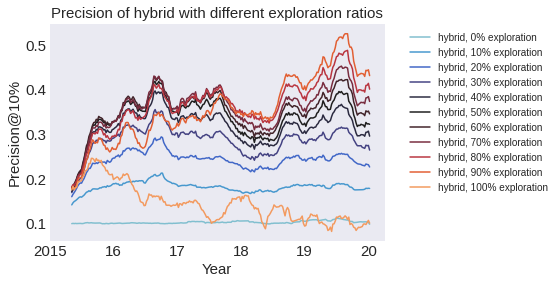

In [ ]:
full_results = extract(['main-all'], ['data', 'sampling', 'subsamplings', 'ada_algo', 'ada_discount', 'ada_decay', 'current_weights'])
draw(full_results, label2key = label, title = 'Precision of hybrid with different exploration ratios')

## Exp 2: Rada

265
The number of trials for each setting (Results are averaged):
real-t,hybrid,xgb/random,-,-,-,-,0.0/1.0 5 0.1031 0.1042 0.1064 0.1027
real-t,hybrid,xgb/random,-,-,-,-,0.1/0.9 5 0.1836 0.1798 0.1823 0.1764
real-t,hybrid,xgb/random,-,-,-,-,1.0/0.0 5 0.1295 0.1122 0.1029 0.095
real-t,rada,xgb/random,exp3s,decay,0.9,balance,0.9/0.1 5 0.3753 0.3826 0.4121 0.3831


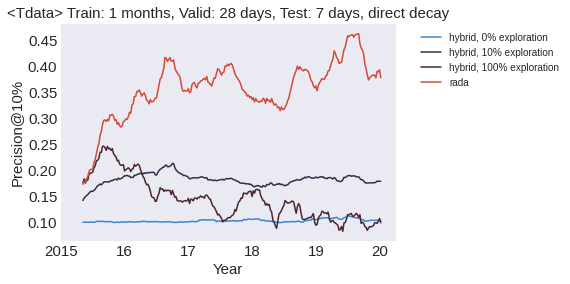

In [ ]:
cond = lambda key: 'exp3s' in key or '0.1/0.9' in key or '1.0/0.0' in key or '0.0/1.0' in key
full_results = extract(['rada-', 'main-all'], ['data', 'sampling', 'subsamplings', 'ada_algo', 'ada_discount', 'ada_decay', 'mixing',  'current_weights'])
draw(full_results, cond=cond, label2key = label)

## Exp 3: Ablation

130
The number of trials for each setting (Results are averaged):
real-t,adahybrid,xgb/random,exp3s,decay,0.9,-,0.9/0.1 5 0.3338 0.3231 0.3567 0.3307
real-t,adahybrid,xgb/random,exp3s,window,0.9,-,0.9/0.1 5 0.3253 0.3259 0.3475 0.3062
real-t,pot,xgb/random,exp3,exp3,-,-,0.9/0.1 5 0.3741 0.3788 0.41 0.3864
real-t,rada,xgb/random,exp3s,decay,0.9,balance,0.9/0.1 5 0.3753 0.3826 0.4121 0.3831


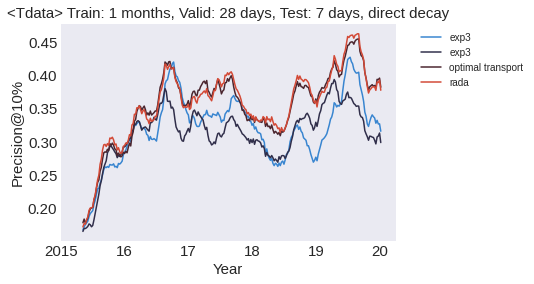

In [ ]:
cond = lambda key: 'exp3s' in key or 'pot' in key
full_results = extract(['rada-', 'main-cd', 'ada'], ['data', 'sampling', 'subsamplings', 'ada_algo', 'ada_discount', 'ada_decay', 'mixing',  'current_weights'])
draw(full_results, cond=cond, label2key = label)

240
The number of trials for each setting (Results are averaged):
real-t,hybrid,xgb/random,-,0.3/0.7 5 0.2925 0.2815 0.2926 0.2733
real-t,hybrid,xgb/random,-,0.9/0.1 5 0.3784 0.4224 0.4648 0.4375
real-t,hybrid,xgb/random,-,1.0/0.0 5 0.1295 0.1122 0.1029 0.095
real-t,pot,xgb/random,-,0.9/0.1 5 0.3741 0.3788 0.41 0.3864


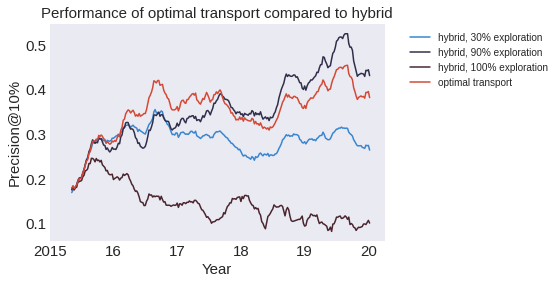

In [ ]:
cond = lambda key: ',hybrid' not in key or '0.9/0.1' in key or '1.0/0.0' in key or '0.3/0.7' in key
draw(extract(['main']), cond = cond, label2key=label, title = 'Performance of optimal transport compared to hybrid')

50
The number of trials for each setting (Results are averaged):
real-t,rada,xgb/random,exp3,window,0.9,balance,0.9/0.1 5 0.373 0.3779 0.4073 0.3769
real-t,rada,xgb/random,exp3,window,0.9,multiply,0.9/0.1 10 0.291 0.3005 0.331 0.3013
real-t,rada,xgb/random,exp3s,decay,0.9,balance,0.9/0.1 5 0.3753 0.3826 0.4121 0.3831


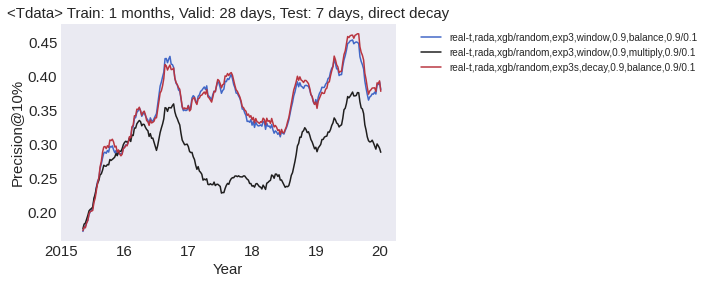

In [ ]:
full_results = extract(['rada-mul', 'rada-'], ['data', 'sampling', 'subsamplings', 'ada_algo', 'ada_discount', 'ada_decay', 'mixing', 'current_weights'])
draw(full_results)

275
The number of trials for each setting (Results are averaged):
real-t,hybrid,xgb/random,-,-,-,-,0.3/0.7 5 0.2925 0.2815 0.2926 0.2733
real-t,hybrid,xgb/random,-,-,-,-,0.9/0.1 5 0.3784 0.4224 0.4648 0.4375
real-t,hybrid,xgb/random,-,-,-,-,1.0/0.0 5 0.1295 0.1122 0.1029 0.095
real-t,pot,xgb/random,exp3,exp3,-,-,0.9/0.1 5 0.3741 0.3788 0.41 0.3864
real-t,rada,xgb/random,exp3,window,0.9,balance,0.9/0.1 5 0.373 0.3779 0.4073 0.3769
real-t,rada,xgb/random,exp3s,decay,0.9,balance,0.9/0.1 5 0.3753 0.3826 0.4121 0.3831


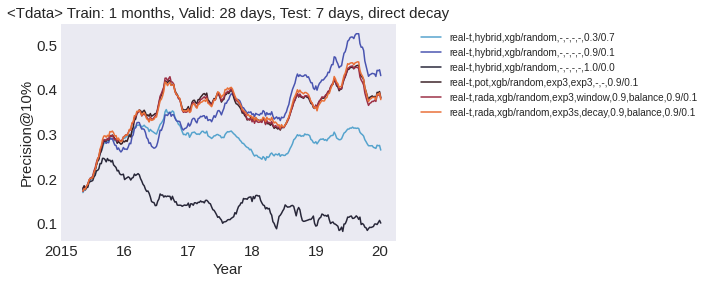

In [ ]:
cond = lambda key: ',hybrid' not in key or '0.9/0.1' in key or '1.0/0.0' in key or '0.3/0.7' in key
full_results = extract(['rada-bal', 'main-all', 'main-cd'], ['data', 'sampling', 'subsamplings', 'ada_algo', 'ada_discount', 'ada_decay', 'mixing',  'current_weights'])
draw(full_results, cond=cond)

In [ ]:
weights = extract_weights(['rada-'])

76


In [ ]:
ratios = extract_ratios(['main-cd-'])
cd = ratios[('1629515408', 'real-t')][13:]
cd

20


13     0.102857
14     0.108571
15     0.116429
16     0.129286
17     0.157857
         ...   
252    0.265714
253    0.259286
254    0.255714
255    0.255714
256    0.252857
Name: current_weights, Length: 244, dtype: float64

In [ ]:
full_results = extract(['rada-'], ['data', 'sampling', 'subsamplings', 'ada_algo', 'ada_discount', 'ada_decay', 'mixing',  'current_weights'])
key = 'real-t,rada,xgb/random,exp3s,decay,0.9,balance,0.9/0.1'
avg_result = pd.concat([*full_results[key]], axis=1).mean(axis=1)[13:]
avg_result

45


13     0.172540
14     0.177861
15     0.176699
16     0.183703
17     0.187553
         ...   
252    0.377136
253    0.389750
254    0.388680
255    0.392647
256    0.377311
Length: 244, dtype: float64

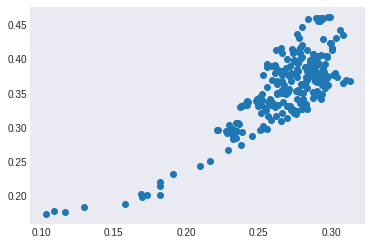

In [62]:
plt.scatter(cd, avg_result)

(0.8426173924489504, 5.403181246165113e-67)

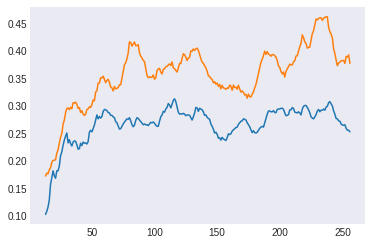

In [63]:
from scipy import stats 
plt.plot(cd)
plt.plot(avg_result)
stats.pearsonr(cd, avg_result)